In [1]:
import alphien
import pandas as pd
import numpy as np

Hello Alkanpam, welcome to Alphien!

Importing your Alphien sub-packages into the alphien namespace...

from alphien.data import *
from alphien.portfolio import *
from alphien.tutorial import *

Importing your Qlib functions...                                   from team:
No functions in Qlib teams: COPPER, alkanpam

Alphien environment imported. Let's do some research now!


In [ ]:
'''
I tried to predict the next 10-days return of copper starting from (n+2)th day to (n+11)th day assuming that current day is nth day
I used LASSO regression to select the relevant features for each period within that particular window size
Then I defined my hyperparameters for random forest classification and used 5-fold time series cross-validation again
If there is no feature selected by LASSO, that day is skipped
If the there is only one selected feature from LASSO and that feature is the same as the previous selected one, the algorithm again skips that day
You can find all the important features printed for that particular day's prediction
If you scroll down, you can find the strategy's result and the copper price movements,
The strategy has an annual gain of 21%

'''

In [2]:
dtf = alphien.DataFeatures(tickers=["LP", 'LMCADY Comdty', 'SPX Index', 'USGG10YR Index', 'DXY Curncy'], fields=["bb_live", 'OHLCV', 'OHLC'])

Dropping duplicated field(s): open_price, high_price, low_price, close_price


In [3]:
copper = dtf.subset(tickers=["LP", 'LMCADY Comdty', 'SPX Index', 'USGG10YR Index', 'DXY Curncy'], fields=["bb_live", 'OHLCV', 'OHLCV', 'OHLC', 'OHLC'])
copper_price = copper.pxs
copper = copper_price.dropna(axis='columns', how ='all')
copper = copper.loc[:,~copper.columns.duplicated()]

Dropping duplicated field(s): open_price, high_price, low_price, close_price, volume, open_price, high_price, low_price, close_price, open_price, high_price, low_price, close_price


In [4]:
n=10
copper['days_volume_sum'] = np.zeros(shape=(len(copper),1))
for i in range(2, len(copper)):
    copper['days_volume_sum'][i] = copper['LMCADY Comdty.volume'][i-n+1:i+1].sum()
    
copper['days_low_price'] = np.zeros(shape=(len(copper),1))
for i in range(2, len(copper)):
    copper['days_low_price'][i] = copper["LMCADY Comdty.low_price"][i-n+1:i+1].min()

copper['days_high_price'] = np.zeros(shape=(len(copper),1))
for i in range(2, len(copper)):
    copper['days_high_price'][i] = copper["LMCADY Comdty.high_price"][i-n+1:i+1].max()

copper["VWAP_futures"] = ((copper['days_high_price']+copper['days_low_price']+copper["LMCADY Comdty.close_price"])/3) * copper['days_volume_sum']
copper["volume_price"] = copper['LP.bb_live'].pct_change(n)*copper['days_volume_sum']
copper.drop(['days_volume_sum', 'days_low_price','days_high_price'], axis=1, inplace=True)

In [5]:
def slow_stochastic_oscillator(df, open_price, high_price, low_price, close_price, asset):
    df["14-high"] = df[high_price].rolling(14, min_periods=1).max()
    df["14-low"] = df[low_price].rolling(14, min_periods=1).min()
    df['%K']= (df[close_price] - df['14-low'])*100/(df['14-high'] - df['14-low'])
    df['%D_{}'.format(asset)] = df['%K'].rolling(3, min_periods=1).mean()
    df['%D_3daychange{}'.format(asset)] = df['%D_{}'.format(asset)].pct_change(3)
    df.drop(["14-high", "14-low",'%K'], axis=1, inplace=True)

In [6]:
slow_stochastic_oscillator(copper, 'LMCADY Comdty.open_price', 'LMCADY Comdty.high_price', 'LMCADY Comdty.low_price', 'LMCADY Comdty.close_price', 'copper')
slow_stochastic_oscillator(copper, 'SPX Index.open_price', 'SPX Index.high_price', 'SPX Index.low_price', 'SPX Index.close_price', 'sp500')
slow_stochastic_oscillator(copper, 'USGG10YR Index.open_price', 'USGG10YR Index.high_price', 'USGG10YR Index.low_price', 'USGG10YR Index.close_price', 'treasury')
slow_stochastic_oscillator(copper, 'DXY Curncy.open_price', 'DXY Curncy.high_price', 'DXY Curncy.low_price', 'DXY Curncy.close_price', 'dxy')

In [7]:
from scipy.stats import skew 
def skewness(df, price, asset, n=50):
    df['skewness_{}'.format(asset)] = price.pct_change().rolling(window=n).skew()
skewness(copper, copper['LP.bb_live'], 'copper')
skewness(copper, copper['SPX Index.close_price'], 'sp500')
skewness(copper, copper['USGG10YR Index.close_price'], 'treasury')
skewness(copper, copper['DXY Curncy.close_price'], 'dxy')

In [8]:
def volatility(df, price, asset, n=50):
    df['volatility_{}'.format(asset)] = price.pct_change().rolling(window=n).std()   
volatility(copper, copper['LP.bb_live'], 'copper')
volatility(copper, copper['SPX Index.close_price'], 'sp500')
volatility(copper, copper['USGG10YR Index.close_price'], 'treasury')
volatility(copper, copper['DXY Curncy.close_price'], 'dxy')

In [9]:
def momentum(returns, price, asset):
    returns['momentum_20_50_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    returns['momentum_8_20_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    for i in range(49, len(price)):
        if price[i-19:i+1].mean() > price[i-49:i+1].mean():
            returns['momentum_20_50_{}'.format(asset)][i] = 1
        if price[i-19:i+1].mean() < price[i-49:i+1].mean():
            returns['momentum_20_50_{}'.format(asset)][i] = 0
        if price[i-7:i+1].mean() > price[i-19:i+1].mean():
            returns['momentum_8_20_{}'.format(asset)][i] = 1
        if price[i-7:i+1].mean() < price[i-19:i+1].mean():
            returns['momentum_8_20_{}'.format(asset)][i] = 0
            
momentum(copper, copper['LP.bb_live'], 'copper')
momentum(copper, copper['SPX Index.close_price'], 'sp500')
momentum(copper, copper['USGG10YR Index.close_price'], 'treasury')
momentum(copper, copper['DXY Curncy.close_price'], 'dxy')

In [10]:
def top_bottom_distance(returns, price, asset, n=20):
    returns['dist_to_bottom_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    returns['dist_to_top_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    
    for i in range(n, len(price)):
        returns['dist_to_bottom_{}'.format(asset)][i] = (price[i]- price[i-n+1:i+1].min())/price[i]
        returns['dist_to_top_{}'.format(asset)][i] = (price[i-n+1:i+1].max()- price[i])/price[i]
        
top_bottom_distance(copper, copper['LP.bb_live'], 'copper')
top_bottom_distance(copper, copper['SPX Index.close_price'], 'sp500')
top_bottom_distance(copper, copper['USGG10YR Index.close_price'], 'treasury')
top_bottom_distance(copper, copper['DXY Curncy.close_price'], 'dxy')

In [11]:
def rsi(df, price, asset, n=14):
    deltas = np.diff(price)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(price)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(price)):
        delta = deltas[i-1] # cause the diff is 1 shorter

        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
    
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)
        
    df['rsi_{}'.format(asset)] = rsi
    df['rsi_change_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    df['macd_rsi_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    
    
    df['rsi_change_{}'.format(asset)] = df['rsi_{}'.format(asset)].pct_change(3)

    df['macd_rsi_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    for i in range(25, len(price)):
        if df['rsi_{}'.format(asset)][i-11:i+1].mean() > df['rsi_{}'.format(asset)][i-25:i+1].mean():
            df['macd_rsi_{}'.format(asset)][i] = 1
        if df['rsi_{}'.format(asset)][i-11:i+1].mean() < df['rsi_{}'.format(asset)][i-22:i+1].mean():
            df['macd_rsi_{}'.format(asset)][i] = 0

rsi(copper, copper['LP.bb_live'], 'copper')
rsi(copper, copper['SPX Index.close_price'], 'sp500')
rsi(copper, copper['USGG10YR Index.close_price'], 'treasury')
rsi(copper, copper['DXY Curncy.close_price'], 'dxy')

In [12]:
def volume_price_actions(df, close, volume, asset, n=10):
    df['{}dayvolume_price_{}'.format(n, asset)] = df[volume].pct_change(n)* df[close].pct_change(n) 
volume_price_actions(copper, 'LMCADY Comdty.close_price', 'LMCADY Comdty.volume', 'copper')
volume_price_actions(copper, 'SPX Index.close_price', 'SPX Index.volume', 'sp500')
volume_price_actions(copper, 'USGG10YR Index.close_price','USGG10YR Index.volume', 'treasury')

In [13]:
def distance_to_top_and_bottom(copper, price, asset, n=20):
    copper['dist_top_band_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    copper['dist_bottom_band_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    for i in range(n, len(price)):
        std = price[i-n+1:i+1].std()
        mean = price[i-n+1:i+1].mean()
        bollinger_top = mean + 2*std
        bollinger_bottom = mean - 2*std
        copper['dist_top_band_{}'.format(asset)][i] = (bollinger_top - price[i])/price[i]
        copper['dist_bottom_band_{}'.format(asset)][i] = (price[i] - bollinger_bottom)/price[i]
        
distance_to_top_and_bottom(copper, copper['LP.bb_live'], 'copper')
distance_to_top_and_bottom(copper, copper['SPX Index.close_price'], 'sp500')
distance_to_top_and_bottom(copper, copper['USGG10YR Index.close_price'], 'treasury')
distance_to_top_and_bottom(copper, copper['DXY Curncy.close_price'], 'dxy')

In [14]:
def difference_from_mean(df, price, asset, n=50):
    df['difference_from_mean_{}'.format(asset)] = np.zeros(shape=(len(price),1))
    for i in range(n, len(price)):
        df['difference_from_mean_{}'.format(asset)][i] = (price[i] - price[i-n:i].mean())/price[i-n:i].mean()
difference_from_mean(copper, copper['LP.bb_live'], 'copper')
difference_from_mean(copper, copper['SPX Index.close_price'], 'sp500')
difference_from_mean(copper, copper['USGG10YR Index.close_price'], 'treasury')
difference_from_mean(copper, copper['DXY Curncy.close_price'], 'dxy')

In [15]:
import numpy.ma as ma
def correlation_tricks(df, price, sp500, treasury, dxy, n=50):
    price_pct_change = price.pct_change()
    sp500_pct_change = sp500.pct_change()
    treasury_pct_change = treasury.pct_change()
    dxy_pct_change = dxy.pct_change()
    
    sp500_pct_change_n = sp500.pct_change(10)
    treasury_pct_change_n = treasury.pct_change(10)
    dxy_pct_change_n = dxy.pct_change(10)
    df['correlation_with_sp500'] = np.zeros(shape=(len(price),1))
    df['correlation_with_treasury'] = np.zeros(shape=(len(price),1))
    df['correlation_with_dxy'] = np.zeros(shape=(len(price),1))
    df['correlation_with_sp500_times_returns'] = np.zeros(shape=(len(price),1))
    df['correlation_with_treasury_times_returns'] = np.zeros(shape=(len(price),1))
    df['correlation_with_dxy_times_returns'] = np.zeros(shape=(len(price),1))
    
    for i in range(n, len(df)):
        df['correlation_with_sp500'][i] = ma.corrcoef(ma.masked_invalid(price_pct_change[i-n+1:i+1]), ma.masked_invalid(sp500_pct_change[i-n+1:i+1]))[0][1]
        df['correlation_with_treasury'][i] = ma.corrcoef(ma.masked_invalid(price_pct_change[i-n+1:i+1]), ma.masked_invalid(treasury_pct_change[i-n+1:i+1]))[0][1]
        df['correlation_with_dxy'][i] = ma.corrcoef(ma.masked_invalid(price_pct_change[i-n+1:i+1]), ma.masked_invalid(dxy_pct_change[i-n+1:i+1]))[0][1]
        
    df['correlation_with_sp500_times_returns'] = df['correlation_with_sp500']*sp500_pct_change_n
    df['correlation_with_treasury_times_returns'] = df['correlation_with_treasury']*treasury_pct_change_n
    df['correlation_with_dxy_times_returns'] = df['correlation_with_dxy']*dxy_pct_change_n

correlation_tricks(copper, copper['LP.bb_live'], copper['SPX Index.close_price'], copper['USGG10YR Index.close_price'], copper['DXY Curncy.close_price'])

In [17]:
def lagged_returns(df, assets, labels=['copper', 'sp500', 'treasury', 'dxy'], n=[5,10, 20, 50]):
    for i in n:
        for j in range(len(assets)):
            df['lagged{}_{}'.format(i, labels[j])] = assets[j].pct_change(i) 
real_returns = np.zeros(shape=(len(copper),1))
real_returns = copper['LP.bb_live'].pct_change(1)

In [18]:
lagged_returns(copper, assets=[copper['LP.bb_live'], copper['SPX Index.close_price'], copper['USGG10YR Index.close_price'], copper['DXY Curncy.close_price']], labels=['copper', 'sp500', 'treasury', 'dxy'], n=[5,20])

In [19]:
n=10
copper['return'] = np.zeros(shape=(len(copper)))
for i in range(len(copper)-n-1):
    copper['return'][i] = (copper['LP.bb_live'][i+n+1]-copper['LP.bb_live'][i+1])/copper['LP.bb_live'][i+1]
    
real_returns = np.zeros(shape=(len(copper),1))
real_returns = copper['LP.bb_live'].pct_change(1)
real_returns = real_returns[50:]

In [20]:
copper = copper[50:]

In [21]:
from math import sqrt

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split,cross_val_score,cross_validate
from sklearn.model_selection import TimeSeriesSplit

from sklearn import linear_model
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier


import time


random_state = np.random.RandomState(0)

In [22]:
copper.drop(['LP.bb_live',
'LMCADY Comdty.open_price',
'LMCADY Comdty.high_price',
'LMCADY Comdty.low_price',
'LMCADY Comdty.close_price',
'LMCADY Comdty.volume',
'SPX Index.open_price',
'SPX Index.high_price',
'SPX Index.low_price',
'SPX Index.close_price',
'SPX Index.volume',
'USGG10YR Index.open_price',
'USGG10YR Index.high_price',
'USGG10YR Index.low_price',
'USGG10YR Index.close_price',
'USGG10YR Index.volume',
'DXY Curncy.open_price',
'DXY Curncy.high_price',
'DXY Curncy.low_price',
'DXY Curncy.close_price'], axis=1, inplace=True)

In [25]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [200, 300]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [10, 30, 70, 90]
# Minimum number of samples required to split a node
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)


{'max_depth': [10, 30, 70, 90],
 'min_samples_leaf': [1],
 'min_samples_split': [2],
 'n_estimators': [200, 300]}


In [108]:
# You can ignore the prints but I just tried to show what features are used for prediction and what are they
# some days there was no feature important so the algorithm just skipped that day

n_splits = 5 #Number of train/cv/test folds
pca = PCA()
scaler = StandardScaler()
window_size = 400
change_window_size = 100

max_depth = []
min_samples_leaf = []
min_samples_split = []
n_estimators = []
scores_ = []
correct = 0
total_number = 0
n_ = []
accuracy_ = []
columns_=[0]

true_return=[]

n = 0
last_corrects = 0
last_incorrects = 0

original_signals = np.zeros(shape=(len(copper),1))

while n < len(copper)-window_size:
    print(n)
    scores = []
    coefs = []
    columns = []
    pd.options.mode.use_inf_as_na = True
    copper.iloc[n:n+window_size+1].fillna(copper.iloc[n:n+window_size+1].max(),inplace=True)
    data = pd.DataFrame(scaler.fit_transform(copper.iloc[n:n+window_size+1]), columns =copper.columns)
    pd.options.mode.use_inf_as_na = False
    scaled_data = data.fillna(0)

    #data = data.fillna(0)
    #scaled_data = pd.DataFrame(pca.fit_transform(data.iloc[:,:-1]), columns =copper.columns[:-1])
    #scaled_data['return'] = data.iloc[:,-1]
    
    scaled_data.index = copper[n:n+window_size+1].index
    scaled_data_ = scaled_data.iloc[:,:]
    
    scaled_data = scaled_data.iloc[:-1,]
    scaled_data['return'] = copper.iloc[n:n+window_size,-1]
    y_true = copper.iloc[n+window_size,-1]
    
    trainTestSplit = TimeSeriesSplit(n_splits)

    for trainCvIndices, testIndices in trainTestSplit.split(scaled_data):
        # First, we split Train + CV and Test
        XTrainCv, yTrainCv = scaled_data.iloc[trainCvIndices,:-1], scaled_data.iloc[trainCvIndices,-1]
        XTest, yTest       = scaled_data.iloc[testIndices,:-1]   , scaled_data.iloc[testIndices,-1]
    
        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
        testLength = len(XTest)
        trainCvSplit = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
        
    modelCV = LassoCV(fit_intercept = False, max_iter = 100000, tol = 0.0001, cv = trainTestSplit).fit(XTrainCv,yTrainCv)
    coefs.append(modelCV.coef_)
        
    columns = []

    for i in range(len(coefs[0])):
        if coefs[0][i] != 0:
            columns.append(scaled_data.columns[i])
        if i == len(coefs[0])-1:
            columns.append('return')
    n +=1
    print('col', len(columns)-1)
    if len(columns) < 2:
        continue
        
    if (len(columns) ==2) and columns == columns_[-1]:
        continue
        
    columns_.append(columns)
        
    # RANDOM FOREST REGRESSOR

    scaled_data = scaled_data[columns]
    for i in range(len(scaled_data['return'])):
        if scaled_data['return'][i] > 0.0:
            scaled_data['return'][i] = 1
        #elif scaled_data['return'][i] < -0.01:
        #    scaled_data['return'][i] = -1
        else:
            scaled_data['return'][i] = -1
    
    train_MSE = []
    best_p = []
    
    n_splits = 5
    trainTestSplit = TimeSeriesSplit(n_splits)

    
    for trainCvIndices, testIndices in trainTestSplit.split(scaled_data):
        XTrainCv, yTrainCv = scaled_data.iloc[trainCvIndices,:-1], scaled_data.iloc[trainCvIndices,-1]
        XTest, yTest       = scaled_data.iloc[testIndices,:-1]   , scaled_data.iloc[testIndices,-1]
    
        # Then, we build a list of the form [ ( [...Train Indices...], [...CV Indices...]  )]
        testLength = len(XTest)
        trainCvSplit = [(list(range(trainCvIndices[0],trainCvIndices[-testLength])),
                     list(range(trainCvIndices[-testLength],trainCvIndices[-1]+1)))]
        
    rf = RandomForestClassifier(class_weight='balanced', random_state=random_state)
    rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, cv = trainTestSplit)
    rf_random.fit(scaled_data.iloc[:,:-1],scaled_data.iloc[:,-1])
    #XTest = XTest[:5]
    #yTest = yTest[:5]
    #y_pred = rf_random.predict(XTest)
    #scores_.append(rf_random.score(XTest, yTest))
    #best_p.append(rf_random.best_params_)
           
    
    max_depth.append(rf_random.best_params_['max_depth'])
    min_samples_leaf.append(rf_random.best_params_['min_samples_leaf'])
    min_samples_split.append(rf_random.best_params_['min_samples_split'])
    n_estimators.append(rf_random.best_params_['n_estimators'])
                         

    final_regression = RandomForestClassifier(class_weight='balanced', random_state=random_state, n_estimators=rf_random.best_params_['max_depth'], max_depth=rf_random.best_params_['min_samples_leaf'], min_samples_split=rf_random.best_params_['min_samples_split'], min_samples_leaf = rf_random.best_params_['n_estimators']) 
    final_regression.fit(scaled_data.iloc[:,:-1], scaled_data.iloc[:,-1])
    
    
    x_true = pd.DataFrame()
    for i in range(len(columns[:-1])):
        x_true[columns[i]] = [scaled_data_.iloc[-1,:-1][columns[:-1]][i]]
    final_y_pred = final_regression.predict(x_true)
    #print('y_true', y_true)
    #print('y_pred', final_y_pred)
    
    if (final_y_pred == 1 and y_true > 0.0) or (final_y_pred == -1 and y_true < -0.0) or ((final_y_pred == 0 and y_true < 0.0) and (final_y_pred == 0 and y_true > -0.0)) :
        print('Correct!!! ...', 'prediction: ', final_y_pred, 'true return: ', y_true)
        true_return.append(round(abs(y_true),5))
        correct += 1
        accuracy_.append(1)
        last_incorrects = 0
        
        if window_size == change_window_size:
            last_corrects += 1
        
    else:
        print('Not Correct:( ...', 'prediction: ', final_y_pred, 'true return: ', y_true)
        true_return.append(-round(abs(y_true),5))
        accuracy_.append(0)
        last_corrects = 0
        last_incorrects +=1
                         
    if (last_corrects > 0 and last_incorrects <= 2) or (last_corrects = 0 and last_incorrects >= 3):
        window_size = change_window_size
    else:
        window_size = 400
        
    print('n: ', n)
    print('what are they?', scaled_data[columns].columns[:-1])
    n_.append(n)
    total_number += 1
    original_signals[n+window_size] = final_y_pred
    
    n += 10





0
col 2
Correct!!! ... prediction:  [1.] true return:  0.046828724443912506
n:  1
what are they? Index(['momentum_20_50_sp500', 'momentum_20_50_dxy'], dtype='object')
11
col 1
Correct!!! ... prediction:  [-1.] true return:  -0.10797124356031418
n:  12
what are they? Index(['momentum_20_50_dxy'], dtype='object')
22
col 0
23
col 0
24
col 0
25
col 0
26
col 0
27
col 0
28
col 1
29
col 0
30
col 1
31
col 1
Correct!!! ... prediction:  [1.] true return:  0.04980206489562988
n:  32
what are they? Index(['correlation_with_treasury'], dtype='object')
42
col 2
Not Correct:( ... prediction:  [1.] true return:  -0.01082372572273016
n:  43
what are they? Index(['momentum_20_50_dxy', 'correlation_with_treasury'], dtype='object')
53
col 1
Correct!!! ... prediction:  [1.] true return:  0.05384708568453789
n:  54
what are they? Index(['correlation_with_treasury'], dtype='object')
64
col 0
65
col 0
66
col 1
Correct!!! ... prediction:  [-1.] true return:  -0.03389448672533035
n:  67
what are they? Index(['v

In [296]:
#We are taking either 10% profit or -10% loss

payout = np.zeros(shape=(len(original_signals),1))
for i in range(len(real_returns)):
    #print(i)
    if original_signals[i] != 0:
        signals = []
        for k in range((10)):
            if (i+k == len(payout)-1):
                break

            signals.append(real_returns[i+2+k]*original_signals[i])
            cum_signal_return = np.cumprod(1+pd.Series(signals))
            
            if ((1-cum_signal_return.iloc[-1]) < 0.10) and ((1-cum_signal_return.iloc[-1]) > -0.10):
                payout[i+1+k] = original_signals[i]
                
            else:
                break
        

In [297]:
final_signals = np.zeros(shape=(len(original_signals),1))

for i in range(len(copper)):
    if original_signals[i] != 0:
        final_signals[i] = original_signals[i]
    if payout[i] != 0:
        final_signals[i] = payout[i]
        

In [298]:
final_returns = np.zeros(shape=(len(original_signals),1))
for i in range(len(final_returns)-2):
    final_returns[i+2] = final_signals[i][0]*real_returns[i+2]

In [299]:
final_returns_=[]
for i in final_returns:
    final_returns_.append(float(i))
    
#np.cumprod(1+pd.Series(final_returns_[window_size:n+window_size])).plot()

([<matplotlib.axis.YTick at 0x7ff66aa49438>,
 <a list of 11 Text yticklabel objects>)

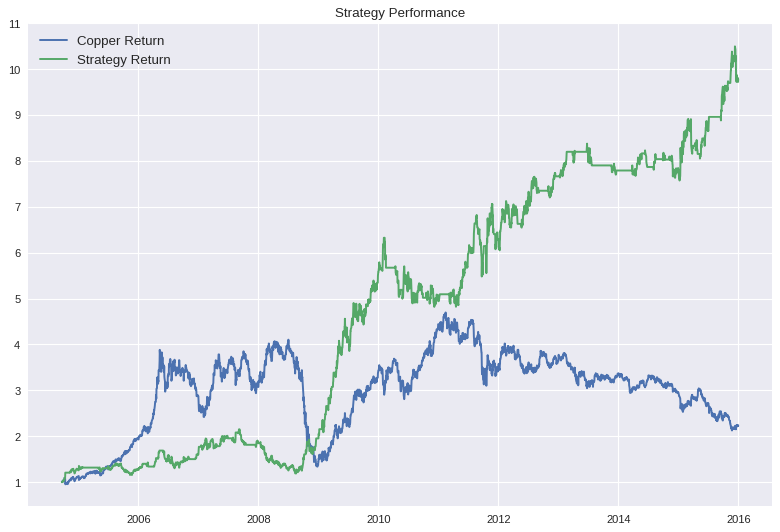

In [300]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

final_returns__ = np.cumprod(1+pd.Series(final_returns_[window_size:n+window_size]))
final_returns__.index = real_returns[window_size:].index
real_returns__ = np.cumprod(1+real_returns[window_size:])
plt.plot(real_returns__, label = 'Copper Return')
plt.plot(final_returns__, label= 'Strategy Return')
plt.legend(loc="upper left", fontsize =12)
plt.title('Strategy Performance')
plt.yticks(np.arange(min(final_returns__), round(max(final_returns__+2)), 1))

In [325]:
sharpe = []
for i in final_returns_:
    if i !=0:
        sharpe.append(i)
print('sharpe ratio', pd.Series(sharpe).mean()/pd.Series(sharpe).std())
factor = len(final_returns__)/252
print('annualized gain', (final_returns__[-1])**(1/factor)-1 )

sharpe ratio 0.0756686828138377
annualized gain 0.21568197605436934


In [ ]:
max_depth_dict = dict()
min_samples_leaf_dict = dict()
min_samples_split_dict = dict()
n_estimators_dict = dict()
    

for i in max_depth:

    if i in max_depth_dict.keys():
        max_depth_dict[i] += 1
    else:
        max_depth_dict[i] = 1

for i in min_samples_leaf:
    if i in min_samples_leaf_dict.keys():
        min_samples_leaf_dict[i] += 1
    else:
        min_samples_leaf_dict[i] = 1
    
for i in min_samples_split:
    if i in min_samples_split_dict.keys():
        min_samples_split_dict[i] += 1
    else:
        min_samples_split_dict[i] = 1
        
for i in n_estimators:
    if i in n_estimators_dict.keys():
        n_estimators_dict[i] += 1
    else:
        n_estimators_dict[i] = 1